## Introduction | forecasting for telecom operator
Telecom company is called Interconnect. The goal is to determine which customers are planning to leave the company's services.To make projections, we will use Machine Learning to determine the categorical prediction. The steps taken will be to:  Preprocess the information; do a thorough EDA; and use predictive modeling.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
from random import shuffle
from sklearn.utils import shuffle
from sklearn.impute import KNNImputer


contract_df = pd.read_csv('/datasets/final_provider/contract.csv')
clients_df = pd.read_csv('/datasets/final_provider/personal.csv')
internet_df = pd.read_csv('/datasets/final_provider/internet.csv')
phone_df = pd.read_csv('/datasets/final_provider/phone.csv')

In [2]:
contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [3]:
display(contract_df.describe())
contract_df.info()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
print('The data imballen(contract_df[contract_df['EndDate'] == "No"]) / len(contract_df["EndDate"])


0.7346301292063041

The data is imbalanced with 73.4% favorable to the "no" end date (customers who are still active).

In [5]:
# Rename columns
contract_df.rename(columns={"customerID": "customer_id", "BeginDate": "begin_date", "EndDate": "end_date",\
                         "Type":"type", "PaperlessBilling":"paperless_billing", "PaymentMethod":"paperless_billing",\
                        "PaymentMethod":"payment_method","MonthlyCharges":"monthly_charges","TotalCharges":"total_charges"},\
               inplace=True)
contract_df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [6]:
print('contract_df NaNs:', contract_df.isna().sum().sum())
print()
print('contract_df duplicates:', contract_df.duplicated().sum())

contract_df NaNs: 0

contract_df duplicates: 0


In [7]:
contract_df[contract_df['end_date'] == ""].shape[0]

0

In [8]:
# Changing begin_date type.
contract_df.begin_date = pd.to_datetime(contract_df.begin_date)

# Transform total_charges column all the empty values (" ") to zeros.
contract_df.loc[contract_df.total_charges == " " , 'total_charges'] = 0.00

# Changing total_charges type to floating points.
contract_df.total_charges = pd.to_numeric(contract_df.total_charges, downcast='float')
contract_df.monthly_charges = contract_df.monthly_charges.astype('float32')

print('total_charges mean', contract_df.total_charges.mean())
display(contract_df.describe())

total_charges mean 2279.7344


,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761696,2279.734375
std,30.090048,2266.794434
min,18.250000,0.000000
25%,35.500000,398.549988
50%,70.349998,1394.550049
75%,89.849998,3786.599976
max,118.750000,8684.799805


## Clients_df Pre-processing


In [9]:
clients_df

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [10]:
clients_df.rename(columns={"customerID": "customer_id","SeniorCitizen":"senior_citizen", "Partner":"partner",\
                       "Dependents":"dependents"}, inplace=True)
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
print('clients NaNs:', clients_df.isna().sum().sum())
print()
print('clients duplicates:', clients_df.duplicated().sum())

clients NaNs: 0

clients duplicates: 0


In [12]:
# checking any imbalances
print(clients_df.gender.value_counts())
print()
print(clients_df.gender.value_counts(normalize=True))

Male      3555
Female    3488
Name: gender, dtype: int64

Male      0.504756
Female    0.495244
Name: gender, dtype: float64


In [13]:
# checking imbalances
print(clients_df.senior_citizen.value_counts())
print()
print(clients_df.senior_citizen.value_counts(normalize=True))

0    5901
1    1142
Name: senior_citizen, dtype: int64

0    0.837853
1    0.162147
Name: senior_citizen, dtype: float64


In [14]:
# checking imbalances
print(clients_df.partner.value_counts())
print()
print(clients_df.partner.value_counts(normalize=True))

No     3641
Yes    3402
Name: partner, dtype: int64

No     0.516967
Yes    0.483033
Name: partner, dtype: float64


In [15]:
# checking imbalances
print(clients_df.dependents.value_counts())
print()
print(clients_df.dependents.value_counts(normalize=True))

No     4933
Yes    2110
Name: dependents, dtype: int64

No     0.700412
Yes    0.299588
Name: dependents, dtype: float64


## Internet df preprocessing


In [16]:
internet_df

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [17]:
internet_df.rename(columns={"customerID": "customer_id", "InternetService":"internet_service","OnlineSecurity":"online_security",\
                        "OnlineBackup":"online_backup","DeviceProtection":"device_protection","TechSupport":"tech_support",\
                        "StreamingTV":"streaming_tv","StreamingMovies":"streaming_movies"}, inplace=True)
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [18]:
print('internet NaNs:', internet_df.isna().sum().sum())
print()
print('internet duplicates:', internet_df.duplicated().sum())

internet NaNs: 0

internet duplicates: 0


In [19]:
# checking imbalances
print(internet_df.internet_service.value_counts())
print()
print(internet_df.internet_service.value_counts(normalize=True))
print()

print(internet_df.online_security.value_counts())
print()
print(internet_df.online_security.value_counts(normalize=True))
print()

print(internet_df.online_backup.value_counts())
print()
print(internet_df.online_backup.value_counts(normalize=True))
print()

print(internet_df.device_protection.value_counts())
print()
print(internet_df.device_protection.value_counts(normalize=True))
print()

print(internet_df.tech_support.value_counts())
print()
print(internet_df.tech_support.value_counts(normalize=True))
print()

print(internet_df.streaming_tv.value_counts())
print()
print(internet_df.streaming_tv.value_counts(normalize=True))
print()

print(internet_df.streaming_movies.value_counts())
print()
print(internet_df.streaming_movies.value_counts(normalize=True))

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

Fiber optic    0.561175
DSL            0.438825
Name: internet_service, dtype: float64

No     3498
Yes    2019
Name: online_security, dtype: int64

No     0.63404
Yes    0.36596
Name: online_security, dtype: float64

No     3088
Yes    2429
Name: online_backup, dtype: int64

No     0.559724
Yes    0.440276
Name: online_backup, dtype: float64

No     3095
Yes    2422
Name: device_protection, dtype: int64

No     0.560993
Yes    0.439007
Name: device_protection, dtype: float64

No     3473
Yes    2044
Name: tech_support, dtype: int64

No     0.629509
Yes    0.370491
Name: tech_support, dtype: float64

No     2810
Yes    2707
Name: streaming_tv, dtype: int64

No     0.509335
Yes    0.490665
Name: streaming_tv, dtype: float64

No     2785
Yes    2732
Name: streaming_movies, dtype: int64

No     0.504803
Yes    0.495197
Name: streaming_movies, dtype: float64


This dataframe only has 5517 observations; so we know some of the clients are not included in these services. Some services are neck and neck for customers having the services verses not; while others there is a bigger difference.

## Phone dataframe Preprocessing

In [20]:
phone_df

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


This dataframe only has 6361 rows of observations.  So also we can see some customers don't have service in this dataframe also. 

In [21]:
phone_df.rename(columns={"customerID": "customer_id", "MultipleLines":"multiple_lines"}, inplace=True)

phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [22]:
print('phone NaNs:', phone_df.isna().sum().sum())

print('phone duplicates:', phone_df.duplicated().sum())

phone NaNs: 0
phone duplicates: 0


In [23]:
# checking balance
print(phone_df.multiple_lines.value_counts())
print()
print(phone_df.multiple_lines.value_counts(normalize=True))

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

No     0.532935
Yes    0.467065
Name: multiple_lines, dtype: float64


## Look at Target

In [24]:
contract_df['end_date'].value_counts()


No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

In [25]:
contract_df['end_date'].value_counts(normalize=True)

No                     0.734630
2019-11-01 00:00:00    0.068863
2019-12-01 00:00:00    0.066165
2020-01-01 00:00:00    0.065313
2019-10-01 00:00:00    0.065029
Name: end_date, dtype: float64

In [26]:
contract_df['end_date'] = np.where((contract_df['end_date'] != 'No'), 'Yes', contract_df['end_date'])
contract_df['end_date'].value_counts()

No     5174
Yes    1869
Name: end_date, dtype: int64

Target as been turned to binary answers.

<b> Visual EDA

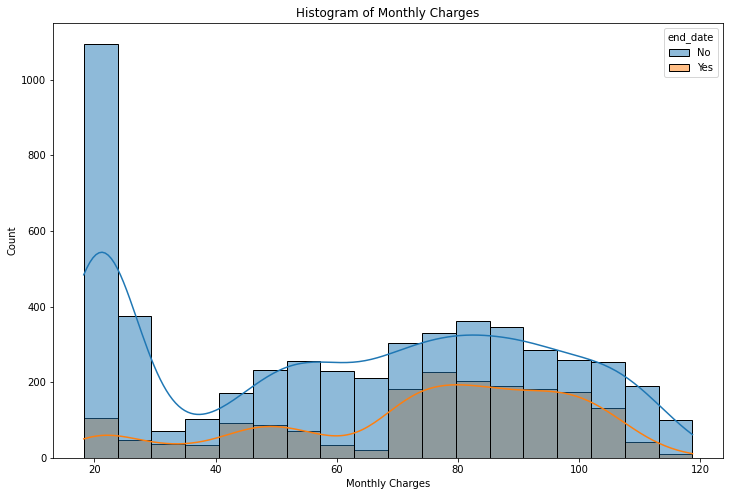

In [27]:
plt.figure(figsize=(12,8))
sns.histplot(x='monthly_charges', data=contract_df, kde=True, hue='end_date')
plt.xlabel('Monthly Charges')
plt.title('Histogram of Monthly Charges')
plt.show()

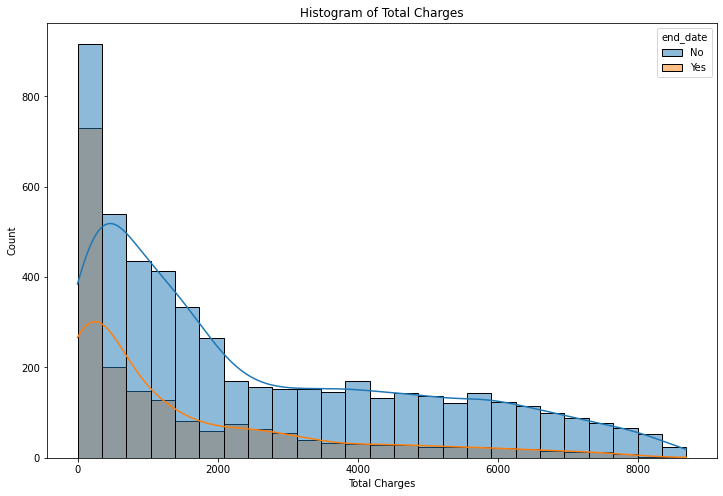

In [28]:
plt.figure(figsize=(12,8))
sns.histplot(x='total_charges', data=contract_df, kde=True, hue='end_date')
plt.xlabel('Total Charges')
plt.title('Histogram of Total Charges')
plt.show()

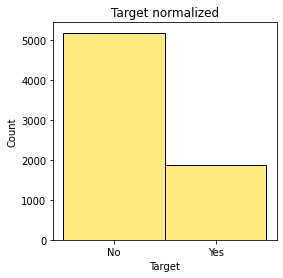


No     0.73463
Yes    0.26537
Name: end_date, dtype: float64


In [29]:
# Seeing Target
plt.figure(figsize=(4,4))
sns.histplot(x='end_date', data=contract_df, color='gold', alpha=.5)
plt.xlabel('Target')
plt.title('Target normalized')
plt.show()
print()
print(contract_df.end_date.value_counts(normalize=True))

Look at how much on average customers were and have been spending on a monthly basis.  Calculate averages for how much on a monthly basis customers who stayed spend; versus those who left spent.

In [30]:
print('monthly_charges mean:', contract_df['monthly_charges'].mean())
print()
print('monthly_charges mean grouped by:', contract_df.groupby('end_date')['monthly_charges'].mean())

monthly_charges mean: 64.761696

monthly_charges mean grouped by: end_date
No     61.265125
Yes    74.441330
Name: monthly_charges, dtype: float32


In [31]:
# Look at the median
print('monthly_charges median:', contract_df['monthly_charges'].median())
print()
print('monthly_charges median grouped by:', contract_df.groupby('end_date')['monthly_charges'].median())

monthly_charges median: 70.35

monthly_charges median grouped by: end_date
No     64.425003
Yes    79.650002
Name: monthly_charges, dtype: float32


In [32]:
# Look at the percentile

print('monthly_charges 25% percentile of "Yes"', np.percentile(contract_df[contract_df.end_date == 'Yes'].monthly_charges, 25))
print('monthly_charges 25% percentile of "No"', np.percentile(contract_df[contract_df.end_date == 'No'].monthly_charges, 25))
print()

print('monthly_charges 75% percentile of "Yes"', np.percentile(contract_df[contract_df.end_date == 'Yes'].monthly_charges, 75))
print('monthly_charges 75% percentile of "No"', np.percentile(contract_df[contract_df.end_date == 'No'].monthly_charges, 75))

monthly_charges 25% percentile of "Yes" 56.150001525878906
monthly_charges 25% percentile of "No" 25.100000381469727

monthly_charges 75% percentile of "Yes" 94.19999694824219
monthly_charges 75% percentile of "No" 88.4000015258789


In [33]:
contract_df['monthly_charges'].describe()

count    7043.000000
mean       64.761696
std        30.090048
min        18.250000
25%        35.500000
50%        70.349998
75%        89.849998
max       118.750000
Name: monthly_charges, dtype: float64

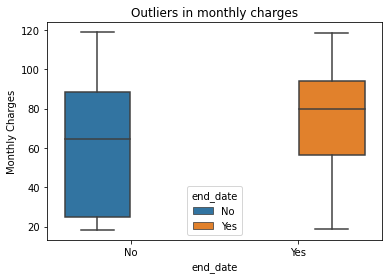

In [34]:
#target monthly_charges boxplot
sns.boxplot(x ='end_date', y='monthly_charges', data=contract_df, hue='end_date')
plt.ylabel('Monthly Charges')
plt.title('Outliers in monthly charges')
plt.show()

EDA analysis<br>
Take notice:  This group of people who may have felt they were spending too much money.  Even on the bottom 25 percentile, they were spending more than double of what the people who stayed were spending.  The standard deviation of payments average 30. Which may be a bit of a large gap.  

In [35]:
# feature engineer a new col
contract_df['target'] = np.where((contract_df['end_date'] != 'No'), 1, contract_df['end_date'])
contract_df['target'].replace('No', 0, inplace=True)
print(contract_df.target.value_counts())

0    5174
1    1869
Name: target, dtype: int64


In [36]:
contract_df['target'] = contract_df['target'].astype('int16')
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float32       
 7   total_charges      7043 non-null   float32       
 8   target             7043 non-null   int16         
dtypes: datetime64[ns](1), float32(2), int16(1), object(5)
memory usage: 399.0+ KB


In [37]:
# Merge Data Frames
df = contract_df.merge(internet_df, on = 'customer_id', how='outer')
df = df.merge(clients_df, on='customer_id', how='outer')
df = df.merge(phone_df, on = 'customer_id', how='outer')

df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,0,DSL,...,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950001,1889.500000,0,DSL,...,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,Yes,Month-to-month,Yes,Mailed check,53.849998,108.150002,1,DSL,...,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,0,DSL,...,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,Yes,Month-to-month,Yes,Electronic check,70.699997,151.649994,1,Fiber optic,...,No,No,No,No,No,Female,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.800003,1990.500000,0,DSL,...,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.199997,7362.899902,0,Fiber optic,...,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.600000,346.450012,0,DSL,...,No,No,No,No,No,Female,0,Yes,Yes,NaN
7041,8361-LTMKD,2019-07-01,Yes,Month-to-month,Yes,Mailed check,74.400002,306.600006,1,Fiber optic,...,No,No,No,No,No,Male,1,Yes,No,Yes


Preparing for encoding.

In [38]:
# feature engineering has_phone feature.
df['has_phone'] = np.where((df['multiple_lines'] == 'No'), 1, np.nan)
df.loc[df['multiple_lines'] == 'Yes', 'has_phone'] = 1
df.has_phone = df['has_phone'].replace(np.nan, 0)
df.has_phone = df.has_phone.astype('int16')
print(df['has_phone'].value_counts(dropna=False))

1    6361
0     682
Name: has_phone, dtype: int64


In [39]:
# feature engineering has_internet feature.
df['has_internet'] = np.where((df['device_protection'] == 'No'), 1, np.nan)
df.loc[df['device_protection'] == 'Yes', 'has_internet'] = 1
df.has_internet = df['has_internet'].replace(np.nan, 0)
df.has_internet = df.has_internet.astype('int16')
print(df['has_internet'].value_counts(dropna=False))

1    5517
0    1526
Name: has_internet, dtype: int64


In [40]:
df

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,internet_service,...,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,has_phone,has_internet
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,0,DSL,...,No,No,No,Female,0,Yes,No,NaN,0,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950001,1889.500000,0,DSL,...,No,No,No,Male,0,No,No,No,1,1
2,3668-QPYBK,2019-10-01,Yes,Month-to-month,Yes,Mailed check,53.849998,108.150002,1,DSL,...,No,No,No,Male,0,No,No,No,1,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,0,DSL,...,Yes,No,No,Male,0,No,No,NaN,0,1
4,9237-HQITU,2019-09-01,Yes,Month-to-month,Yes,Electronic check,70.699997,151.649994,1,Fiber optic,...,No,No,No,Female,0,No,No,No,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.800003,1990.500000,0,DSL,...,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,1,1
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.199997,7362.899902,0,Fiber optic,...,No,Yes,Yes,Female,0,Yes,Yes,Yes,1,1
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.600000,346.450012,0,DSL,...,No,No,No,Female,0,Yes,Yes,NaN,0,1
7041,8361-LTMKD,2019-07-01,Yes,Month-to-month,Yes,Mailed check,74.400002,306.600006,1,Fiber optic,...,No,No,No,Male,1,Yes,No,Yes,1,1


In [41]:

# Columns to one-hot encode
df_encoded = pd.get_dummies(df, columns=['paperless_billing','type',
                                         'payment_method','internet_service',
                                        'online_security','online_backup','device_protection',
                                         'tech_support','streaming_tv','streaming_movies',
                                        'gender','partner','dependents','multiple_lines','end_date'], \
                            drop_first=True)
df_encoded

,customer_id,begin_date,monthly_charges,total_charges,target,senior_citizen,has_phone,has_internet,paperless_billing_Yes,type_One year,...,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,gender_Male,partner_Yes,dependents_Yes,multiple_lines_Yes,end_date_Yes
0,7590-VHVEG,2020-01-01,29.850000,29.850000,0,0,0,1,1,0,...,1,0,0,0,0,0,1,0,0,0
1,5575-GNVDE,2017-04-01,56.950001,1889.500000,0,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,53.849998,108.150002,1,0,1,1,1,0,...,1,0,0,0,0,1,0,0,0,1
3,7795-CFOCW,2016-05-01,42.299999,1840.750000,0,0,0,1,0,1,...,0,1,1,0,0,1,0,0,0,0
4,9237-HQITU,2019-09-01,70.699997,151.649994,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,84.800003,1990.500000,0,0,1,1,1,1,...,0,1,1,1,1,1,1,1,1,0
7039,2234-XADUH,2014-02-01,103.199997,7362.899902,0,0,1,1,1,1,...,1,1,0,1,1,0,1,1,1,0
7040,4801-JZAZL,2019-03-01,29.600000,346.450012,0,0,0,1,1,0,...,0,0,0,0,0,0,1,1,0,0
7041,8361-LTMKD,2019-07-01,74.400002,306.600006,1,1,1,1,1,0,...,0,0,0,0,0,1,1,0,1,1


In [42]:
# reset the index
df_encoded = df_encoded.set_index('customer_id',drop=True)
display(df_encoded)

,begin_date,monthly_charges,total_charges,target,senior_citizen,has_phone,has_internet,paperless_billing_Yes,type_One year,type_Two year,...,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,gender_Male,partner_Yes,dependents_Yes,multiple_lines_Yes,end_date_Yes
customer_id,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,29.850000,29.850000,0,0,0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,0
5575-GNVDE,2017-04-01,56.950001,1889.500000,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
3668-QPYBK,2019-10-01,53.849998,108.150002,1,0,1,1,1,0,0,...,1,0,0,0,0,1,0,0,0,1
7795-CFOCW,2016-05-01,42.299999,1840.750000,0,0,0,1,0,1,0,...,0,1,1,0,0,1,0,0,0,0
9237-HQITU,2019-09-01,70.699997,151.649994,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,84.800003,1990.500000,0,0,1,1,1,1,0,...,0,1,1,1,1,1,1,1,1,0
2234-XADUH,2014-02-01,103.199997,7362.899902,0,0,1,1,1,1,0,...,1,1,0,1,1,0,1,1,1,0
4801-JZAZL,2019-03-01,29.600000,346.450012,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,1,0,0


In [43]:
print(df.target.value_counts())

0    5174
1    1869
Name: target, dtype: int64


The number of non-exited customers is: 5174; while the number of exited customers is: 1869.

In [44]:
df_encoded.columns

Index(['begin_date', 'monthly_charges', 'total_charges', 'target',
       'senior_citizen', 'has_phone', 'has_internet', 'paperless_billing_Yes',
       'type_One year', 'type_Two year',
       'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check',
       'internet_service_Fiber optic', 'online_security_Yes',
       'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes',
       'streaming_tv_Yes', 'streaming_movies_Yes', 'gender_Male',
       'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes', 'end_date_Yes'],
      dtype='object')

## Model build

In [46]:
# Prevent data leakage
features = df_encoded.drop(['begin_date','target','end_date_Yes'], axis=1)
target = df_encoded['target']

#Train test split.
features_train, features_test, target_train, target_test = train_test_split\
(features, target, test_size=0.25, random_state=42)

In [48]:
display(features_train.shape , target_train.shape)

target_test.value_counts()

(5282, 22)

(5282,)

0    1282
1     479
Name: target, dtype: int64

In [50]:
#Creating pipelines.
pipe_rfc = Pipeline([('scaler0', StandardScaler()),
                    ('RandomForestClassifier', RandomForestClassifier(n_estimators=100))])

pipe_lr = Pipeline([('scaler1', StandardScaler()),
                       ('LogisticRegression(Dummy)', LogisticRegression(solver='lbfgs'))])

pipe_lgbm =  Pipeline([('scaler2', StandardScaler()),
                       ('LGBMClassifier', LGBMClassifier())])

catboost_pipeline = Pipeline([('scaler', StandardScaler()),
                        ('catboost', CatBoostClassifier(random_state=42))]) 

In [51]:
#Creating list of pipelines.
pipelines = [pipe_rfc, pipe_lr, pipe_lgbm, catboost_pipeline]
#Creating a dictionary of pipelines.
pipe_dict = {pipe_rfc:'RandomForestClassifier', pipe_lr:'LogisticRegression', \
             pipe_lgbm: 'LGBMClassifier', catboost_pipeline: 'CatBoost'}

In [52]:
for pipe in pipelines:
    print(pipe_dict[pipe])
    print(cross_val_score(pipe, features_train, target_train, scoring = 'roc_auc', cv=5))

RandomForestClassifier
[0.83900915 0.81180216 0.79957371 0.81746685 0.81467191]
LogisticRegression
[0.85595811 0.83990959 0.82221986 0.82047216 0.8307873 ]
LGBMClassifier
[0.85179071 0.82191243 0.81764023 0.81932783 0.82601579]
CatBoost
Learning rate set to 0.019062
0:	learn: 0.6812530	total: 49.5ms	remaining: 49.4s
1:	learn: 0.6685115	total: 52.5ms	remaining: 26.2s
2:	learn: 0.6567168	total: 55.5ms	remaining: 18.4s
3:	learn: 0.6459711	total: 58.5ms	remaining: 14.6s
4:	learn: 0.6346788	total: 61.6ms	remaining: 12.3s
5:	learn: 0.6248765	total: 64.6ms	remaining: 10.7s
6:	learn: 0.6153869	total: 67.6ms	remaining: 9.59s
7:	learn: 0.6077868	total: 70.6ms	remaining: 8.75s
8:	learn: 0.5983505	total: 73.5ms	remaining: 8.1s
9:	learn: 0.5916025	total: 76.5ms	remaining: 7.57s
10:	learn: 0.5850559	total: 79.4ms	remaining: 7.14s
11:	learn: 0.5782275	total: 82.5ms	remaining: 6.79s
12:	learn: 0.5723162	total: 84.9ms	remaining: 6.44s
13:	learn: 0.5648605	total: 87.8ms	remaining: 6.19s
14:	learn: 0.558

In [53]:
#Creating a parameters dictionary for LGBMRegressor possible hyperparameters values.
parameters = {'learning_rate': (0.09, 0.12, 0.1, 0.275),
              'n_estimators': (150, 110, 130, 70, 200), 
              } 

#Creating a grid model.
LGBM_grid = GridSearchCV(LGBMClassifier(), param_grid=parameters, scoring='roc_auc', cv=5) 
LGBM_grid_model = LGBM_grid.fit(features_train, target_train)
print(LGBM_grid_model.best_estimator_)
print(LGBM_grid_model.best_score_)

LGBMClassifier(learning_rate=0.09, n_estimators=70)
0.831446580280779


The results gave me:<br>
RandomForestClassifier<br>
[0.83688274 0.81284344 0.79794391 0.81954282 0.80726036]<br>
LogisticRegression<br>
[0.85595811 0.83990959 0.82221986 0.82047216 0.8307873 ]<br>
LGBMClassifier<br>
[0.85179071 0.82191243 0.81764023 0.81932783 0.82601579]<br>
CatBoost<br>
[0.85747038 0.83588072 0.81447079 0.83134444 0.83804165]<br>

LR, LGBM, and CatBoost having slightly the highest.

In [54]:
#Testing the models
pipe_cat =  Pipeline([('scaler', StandardScaler()),
                       ('catboost', CatBoostClassifier(max_depth = 2, learning_rate=0.12, n_estimators=100, \
                                                             verbose=500, random_state=42))])

pipe_cat.fit(features_train, target_train) 
predictions = pipe_cat.predict(features_test) 

print(f'Accuracy Test: {pipe_cat.score(features_test, target_test):.3f}')
print(f'Accuracy Train: {pipe_cat.score(features_train, target_train):.3f}')
print()

#auc_roc = roc_auc_score(target_test, predictions)
#print('ROC_AUC', auc_roc)
false_positive_rate, true_positive_rate, thresholds = roc_curve(target_test, pipe_cat.predict_proba(features_test)[:,1])
print('AUC:', auc(false_positive_rate, true_positive_rate))

0:	learn: 0.6489163	total: 1.49ms	remaining: 148ms
99:	learn: 0.4043729	total: 125ms	remaining: 0us
Accuracy Test: 0.806
Accuracy Train: 0.807

AUC: 0.862844785190155


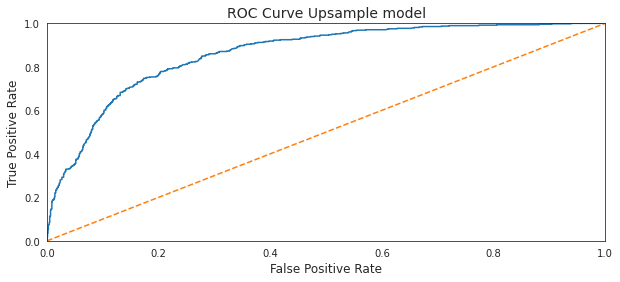

In [55]:
#ROC curve 
probabilities = pipe_cat.predict_proba(features_test)
probabilities_one = probabilities[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one) 

sns.set_style('white')
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve model', fontsize=14)
plt.show()

Solution Report:<br>

<br>
As per the plan; the datasets were preprocessed and examined; a thorough EDA has been performed, as well as datasets were merged and predictive models were built with tests of accuracy included.  I skipped upsampling because I later took care of the imbalancing during pipeline activations.    
Acknowledging the number of non-exited customers is: 5174; while the number of exited customers is: 1869.  And that the customers who left generally spent more money than those who stayed; Were some remarkable findings of the EDA.  <br>
Difficulties incurred were when acknowledging the data was imbalanced; such as our target, having more non-exited customers than exited.  I used a skillset with pipelines and scaling the data to build models and use cross validation. Other difficulties comes in where ML does best with numbers so encoding needed to be performed.  Which took place before the build of models.  I used Pandas get_dummies function for simplicity during the encoding process. I was careful to ensure no data leakage by stripping away certain features; which incurred during my split of the data into features and target, during the divide for training and testing sets. <br>
Key steps in solving the task was to split the data into train and test sets.  Try different models and use hyper parameters expanding the test of certain models.  This was a binary classification test so I used classification models of different types to explore its accuracy of AUC-ROC; showing the height of the true-positive rate. <br>
My final model is a CatBoostClassifier.  Which scored an AUC: 0.862844785190155.